In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from dotenv import load_dotenv
import requests
from datetime import timedelta
import json

import cpi


load_dotenv("../../.env",override=True)
pd.set_option("display.max_columns",500)

c:\Users\jliv\Desktop\research\python_research\.venv\lib\site-packages\cpi\__init__.py:42: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  warnings.warn(StaleDataWarning())


In [29]:
import numpy as np

In [2]:
allItems = cpi.series.get(items='All items',periodicity='Monthly').to_dataframe().sort_values(by='date')



series = {
    'allItems':allItems,
}

for k in series.keys():
    series[k] = series[k][series[k]['period_type']=='monthly'][['year','date','value','series_id','series_items_name']].copy()
    series[k]['inflation'] = series[k]['value']/series[k]['value'].shift(12) - 1
    series[k].index = pd.to_datetime(series[k]['date']).values

allDat = pd.concat(list(series.values()))
allDat['date']=allDat['date'].astype(str)

In [3]:
PE_history = pd.read_html("https://www.multpl.com/s-p-500-pe-ratio/table/by-month")
PE_history = PE_history[0]
PE_history.columns = ['month','sp500 pe']
PE_history['sp500 pe'] = PE_history['sp500 pe'].str.replace(' estimate','').astype(float)
PE_history['month'] = pd.to_datetime(PE_history['month']).astype(str)
PE_history.index = pd.to_datetime(PE_history['month']).values

In [5]:
allDat

,year,date,value,series_id,series_items_name,inflation
1913-01-01,1913,1913-01-01,9.800,CUUR0000SA0,All items,NaN
1913-02-01,1913,1913-02-01,9.800,CUUR0000SA0,All items,NaN
1913-03-01,1913,1913-03-01,9.800,CUUR0000SA0,All items,NaN
1913-04-01,1913,1913-04-01,9.800,CUUR0000SA0,All items,NaN
1913-05-01,1913,1913-05-01,9.700,CUUR0000SA0,All items,NaN
...,...,...,...,...,...,...
2022-04-01,2022,2022-04-01,289.109,CUUR0000SA0,All items,0.082586
2022-05-01,2022,2022-05-01,292.296,CUUR0000SA0,All items,0.085815
2022-06-01,2022,2022-06-01,296.311,CUUR0000SA0,All items,0.090598
2022-07-01,2022,2022-07-01,296.276,CUUR0000SA0,All items,0.085248


In [7]:
PE_history.columns = ['date','sp500_pe']

In [44]:
refPE = np.mean(PE_history[(PE_history['date']>='1982-01-01')&
    (PE_history['date']<='1984-12-01')]['sp500_pe'])

In [45]:
PE_history['sp500_pe_index']=(PE_history['sp500_pe']/refPE)*100


In [53]:
merge = PE_history.merge(allDat[['date','value','inflation']],on=['date'],how='left')

In [54]:
merge = merge[merge['date']>='1980-01-01'].copy()

In [55]:
np.nanmedian(merge['value']/merge['value'].shift(-1))

1.002496368277788

In [56]:
merge.sort_values(by='date',ascending=True,inplace=True)

In [57]:
merge.index = pd.to_datetime(merge['date']).values

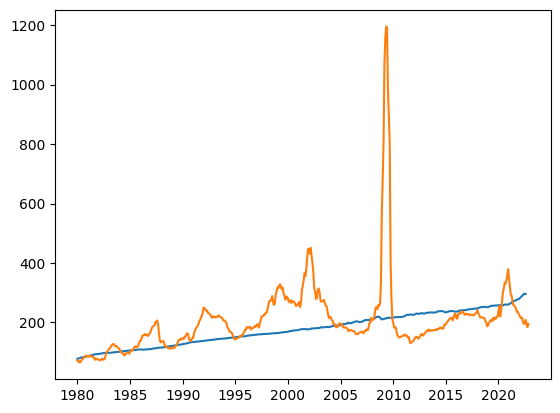

In [58]:
plt.plot(merge['value'])
plt.plot(merge['sp500_pe_index'])

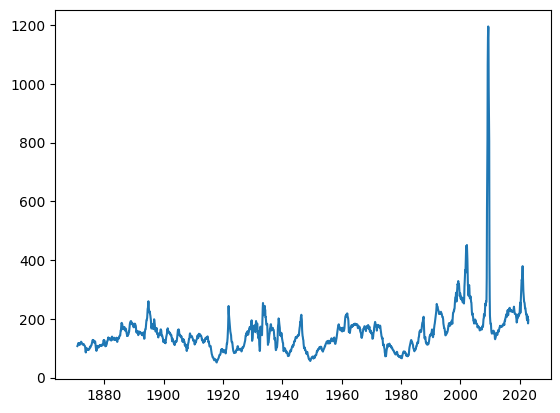

In [52]:
plt.plot(PE_history['sp500_pe_index'])

In [61]:
consumerKey = os.environ.get("CONSUMER_KEY")

url = "https://api.tdameritrade.com/v1/marketdata/$SPX.X/pricehistory?periodType=year&period=20&frequencyType=monthly&frequency=1"
response = requests.get(url,
        params={'apikey' : consumerKey})
SPY = pd.DataFrame(json.loads(response.content)['candles'])
SPY['date'] = pd.to_datetime(SPY['datetime'],unit='ms').dt.date
SPY.index = SPY['date'].values

SPY['month'] = pd.to_datetime(SPY['date']) - pd.to_timedelta(pd.to_datetime(SPY['date']).dt.day-1,unit='d')
SPY['month'] = SPY['month'].astype(str)

In [65]:
SPY= SPY[['date','close']].copy()

In [68]:
SPY['YOYSP500'] = SPY['close'].shift(-12)/SPY['close']

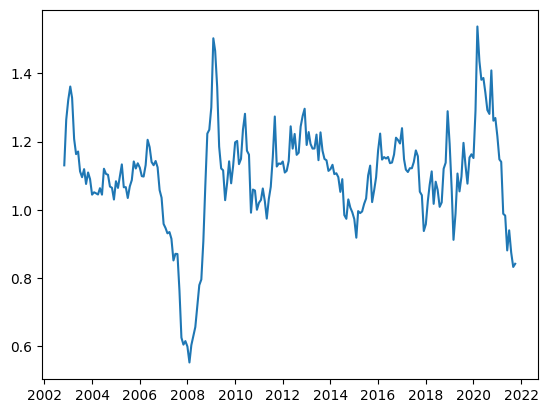

In [69]:
plt.plot(SPY['YOYSP500'])

In [75]:
SPY['date'] = SPY['date'].astype(str)

In [96]:
m2 = merge.merge(SPY,on='date',how='left')

In [97]:
m2['CPI/SP500PE'] = m2['value']/m2['sp500_pe']
m2.index = pd.to_datetime(m2['date'])

In [98]:
m2.corr()

C:\Users\jliv\AppData\Local\Temp\ipykernel_21040\1929086746.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  m2.corr()


,sp500_pe,sp500_pe_index,value,inflation,close,YOYSP500,CPI/SP500PE
sp500_pe,1.000000,1.000000,0.335581,-0.455737,-0.092933,0.217573,-0.560587
sp500_pe_index,1.000000,1.000000,0.335581,-0.455737,-0.092933,0.217573,-0.560587
value,0.335581,0.335581,1.000000,-0.453847,0.895537,0.089264,0.361588
inflation,-0.455737,-0.455737,-0.453847,1.000000,0.378536,-0.445316,0.207882
close,-0.092933,-0.092933,0.895537,0.378536,1.000000,-0.011968,0.144960
YOYSP500,0.217573,0.217573,0.089264,-0.445316,-0.011968,1.000000,-0.103983
CPI/SP500PE,-0.560587,-0.560587,0.361588,0.207882,0.144960,-0.103983,1.000000


In [99]:
m2 = m2[m2['date']>='2000-01-01'].copy()

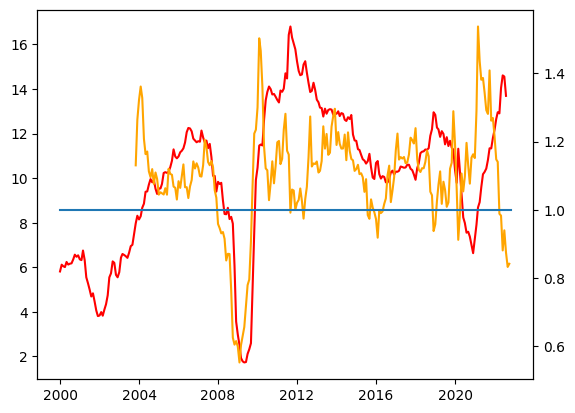

In [100]:
fig,ax1 = plt.subplots()
ax1.plot(m2['CPI/SP500PE'],color='red')
ax2 = ax1.twinx()
ax2.plot(m2['YOYSP500'].shift(12),color='orange')
plt.plot(pd.Series(np.ones(len(m2)),index=list(m2.index)))